In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
import random

In [2]:
# initialization
subjects = 68
types = 13
usePCA = True
useMDA = False
# dataset_file = 'Data/pose.mat'
dataset_file = 'Data/data.mat'
# dataset_file = 'Data/illumination.mat'
dataset = ''

In [3]:
# load the dataset
data_ = sio.loadmat(dataset_file)

In [4]:
if 'pose' in dataset_file:
    data = data_.get('pose')
    dataset = 'pose'
elif 'illumination' in dataset_file:
    data = data_.get('illum')
    dataset = 'illum'
else:
    data = data_.get('face')
    dataset = 'face'

In [5]:
# flatten the dataset
if dataset == 'pose':
    flattened = np.zeros(shape=(subjects*types, data.shape[0]*data.shape[1]))
elif dataset == 'illum':
    flattened = np.zeros(shape=(subjects*types, data.shape[0]))
else:
    flattened = np.zeros(shape=(subjects*types, data.shape[0]*data.shape[1]))

c = 0
d = 0
for i in range(flattened.shape[0]):
    if c == types:
        c = 0
        d += 1
    if dataset == 'pose':
        temp = data[:,:,c,d]
        flattened[i] = temp.flatten()
    elif dataset == 'face':
        temp = data[:,:,i]
        flattened[i] = temp.flatten()
    elif dataset == 'illum':
        flattened[i] = data[:,c,d]
    c += 1


In [6]:
def doPCA(flattened, dim):
    pca = PCA(dim)
    projected = pca.fit_transform(flattened)
    return projected


Minimum dimensions required for 95% retention  199


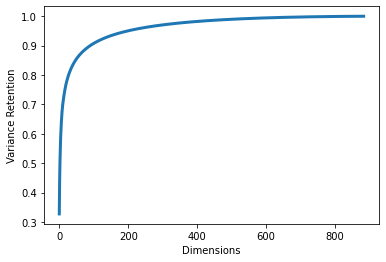

In [7]:
# Perform PCA if true
if usePCA:
    pca = PCA().fit(flattened)
    plt.figure()
    plt.xlabel('Dimensions')
    plt.ylabel('Variance Retention')
    plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)
    min_dim = (np.where(pca.explained_variance_ratio_.cumsum() > 0.95))[0][0]
    print('Minimum dimensions required for 95% retention ', min_dim)
    projected = doPCA(flattened, min_dim)

In [8]:
print('Before dimension reduction shape = ', flattened.shape)
print('After dimension reduction shape = ', projected.shape)

Before dimension reduction shape =  (884, 1920)
After dimension reduction shape =  (884, 199)


In [9]:
# Split in training and testing data set
def genereate_training_testing_data(projected, subjects, types):
    training_data = []
    testing_data = []
    train_per_subject = int(math.ceil(2*types/3))
    test_per_subject = types - train_per_subject
    print('Training data per subject=', train_per_subject)
    print('Testing data per subject=', test_per_subject)

    for i in range(subjects):
        temp = []
        start = i*types
        end = (i+1)*types
        # print(start, start+train_per_subject)
        # print(start+train_per_subject, end)
        # print('-----------------')
        
        for j in range(start , start + test_per_subject):
            testing_data.append(projected[j])
        
        for j in range(start + test_per_subject , end):
            training_data.append(projected[j])
        
        # training_data.append(projected[start : start + train_per_subject])
        # testing_data.append(projected[start + train_per_subject : end])
    print('Size of training data = ', len(training_data))
    print('Size of testing data = ', len(testing_data))
    return training_data, testing_data, train_per_subject, test_per_subject



In [10]:
training_data, testing_data, train_per_subject, test_per_subject = genereate_training_testing_data(projected, subjects, types)

Training data per subject= 9
Testing data per subject= 4
Size of training data =  612
Size of testing data =  272


In [11]:
# Compute the mean and covariance for each training sample
def calculate_covariance_mean(training_data, dataset):
    cov = []
    mu = []
    for i in range(len(training_data)):
        sample = training_data[i]
        size = sample.shape[0]
        sample = sample.reshape(1, size)
        cov_ = np.dot((sample - np.mean(sample)).T, (sample - np.mean(sample))) / size
        # add noise to make determinant non-zero
        if dataset == 'face':
            noise = 0.24*np.identity(cov_.shape[0])
        elif dataset == 'pose':
            noise = 0.03*np.identity(cov_.shape[0])
        else:
            noise = 0.01*np.identity(cov_.shape[0])
            # noise = 0.03*np.identity(cov_.shape[0])
        cov_ = cov_ + noise
        mu.append(np.mean(sample))
        cov.append(cov_)
    return cov, mu

In [12]:
cov, mu = calculate_covariance_mean(training_data, dataset)

In [13]:
np.linalg.det(cov[0])

5.032300389831411e-298

In [21]:
# K-NN
k = 8
score = 0
actual_tests = len(testing_data)
for i in range(len(testing_data)):
    test_class = int(i/test_per_subject)
    dist = np.zeros(shape=(len(training_data)))
    for j in range(len(training_data)):
        # d =  np.dot(testing_data[i] - mu[j], np.dot(np.linalg.inv(cov[j]), (testing_data[i] - mu[j]).T))
        d = np.linalg.norm(testing_data[i] - training_data[j])
        dist[j] = d
    
    sort = np.argsort(dist)
    
    predicted_nearest_class = np.zeros(shape=dist.shape[0])
    votes_class = np.zeros(shape=subjects)

    for l in range(k):
        predicted_nearest_class[l] = int(sort[l]/train_per_subject)
        temp_class = int(predicted_nearest_class[l])
        # print(temp_class)
        votes_class[temp_class] += 1
    
    # print(sort[:k])
    # print(votes_class)
    
    # print(np.where(votes_class == np.max(votes_class)))
    same_votes = (np.where(votes_class == np.max(votes_class)))[0]
    if len(same_votes) > 1:
        print('Same votes, skip this sample')
        actual_tests -= 1
        continue

    votes_class = -1*votes_class
    predicted_class = np.argsort(votes_class)[0]

    print(predicted_class)
    print(test_class)

    if predicted_class == test_class:
        score += 1
        print('Correct, score = ', score)
    else:
        print('Incorrect')
    print('-------------------------------------------')
    
print('Accuracy of ',str(k),'-NN = ', (score*100/actual_tests))

29
0
Incorrect
-------------------------------------------
Same votes, skip this sample
Same votes, skip this sample
Same votes, skip this sample
Same votes, skip this sample
1
1
Correct, score =  1
-------------------------------------------
1
1
Correct, score =  2
-------------------------------------------
Same votes, skip this sample
2
2
Correct, score =  3
-------------------------------------------
2
2
Correct, score =  4
-------------------------------------------
2
2
Correct, score =  5
-------------------------------------------
Same votes, skip this sample
Same votes, skip this sample
Same votes, skip this sample
3
3
Correct, score =  6
-------------------------------------------
Same votes, skip this sample
Same votes, skip this sample
4
4
Correct, score =  7
-------------------------------------------
Same votes, skip this sample
Same votes, skip this sample
Same votes, skip this sample
5
5
Correct, score =  8
-------------------------------------------
Same votes, skip thi

In [2]:
np.zeros(9)

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [3]:
# #pose
# Accuracy of  1 -NN =  88.97058823529412
# Accuracy of  2 -NN =  100.0
# Accuracy of  3 -NN =  96.8944099378882
# Accuracy of  4 -NN =  96.27329192546584
# Accuracy of  5 -NN =  95.86206896551724
# Accuracy of  6 -NN =  92.85714285714286
# Accuracy of  7 -NN =  89.43661971830986
# Accuracy of  8 -NN =  89.78102189781022
# Accuracy of  9 -NN =  89.84375

In [4]:
# Accuracy of  1 -NN =  81.30252100840336
# Accuracy of  2 -NN =  98.59154929577464
# Accuracy of  3 -NN =  92.10526315789474
# Accuracy of  4 -NN =  85.71428571428571
# Accuracy of  5 -NN =  80.72916666666667
# Accuracy of  6 -NN =  75.77319587628865
# Accuracy of  7 -NN =  71.2871287128713
# Accuracy of  8 -NN =  69.89795918367346
# Accuracy of  9 -NN =  69.1919191919192
# Accuracy of  10 -NN =  65.48223350253807
# Accuracy of  11 -NN =  66.16161616161617
# Accuracy of  12 -NN =  67.74193548387096
# Accuracy of  13 -NN =  65.48223350253807
# Accuracy of  14 -NN =  65.28497409326425


In [5]:
# Accuracy of  1 -NN =  55.0
# Accuracy of  2 -NN =  92.85714285714286